---
title: Naive Automata Minimization
date: 2024-07-23
---

A kind of cute way of writing [automata minimization](https://en.wikipedia.org/wiki/DFA_minimization) and some philosophy around why. I learned it from this paper https://arxiv.org/abs/2204.12368 by Jules Jacobs and Thorsten Wißmann.

Automata minimization can be used to answer questions about regular expression equivalence, intersection, unions, emptiness, etc. It is a canonical form for an automata, which is useful for all the usual reasons canonical forms are. Smaller automata may be more efficient also.

States are only meaningfully distinct if they are "observationally" distinct. The "best" representation of an automaton is a `dict[StateLabel, Observation]`, where observations can also self-referentially include transitions to other states.

# Finite State Automata

The main automaton that makes sense is the finite state automaton https://en.wikipedia.org/wiki/Finite-state_machine (DFA or FSA). There is a finite set of states and a finite set of actions. 

We come across these things in the theory and implementation of [regular expressions](https://en.wikipedia.org/wiki/Regular_expression). Or in controllers for vending machines, elevators, and traffic lights and things.

One reason they are nice because they are easy to implement in low level systems as a predefined lookup table/array of `state x actions -> state`. 

In [17]:
# states are integers. actions "a" or action "b"
actiontable = {
    (1, "a") : 2,
    (1, "b") : 3,
    (2, "a") : 2,
    (2, "b") : 3,
    (3, "a") : 2,
    (3, "b") : 3,
    (4, "a") : 5,
    (4, "b") : 6,
    (5, "a") : 4,
    (5, "b") : 4,
}

def step(state , action):
    return actiontable[(state, action)]

state = 1 # initial start
for action in "aaabbbaaa":
    state = step(state, action)
    print(state) 

2
2
2
3
3
3
2
2
2


In the freed but impoverished case of digital logic, it can be easier and more efficient to implement specialized state machines for algorithms than have a full general purpose cpu like design. Kind of there is one state per line of code (you often want to tack on some big state like registers doing some calculation which it is not great to model in the FSA paradigm).

Another reason they are nice, a very important one, is we can present small examples very intuitively by a graph with action labelled edges between state nodes. State machines can go in a powerpoint slide and have a hope of conveying technical information. Visualization is super important.

Here we see the choice of data structure is different than the `actiontable` above. A refactoring of the same state machine.

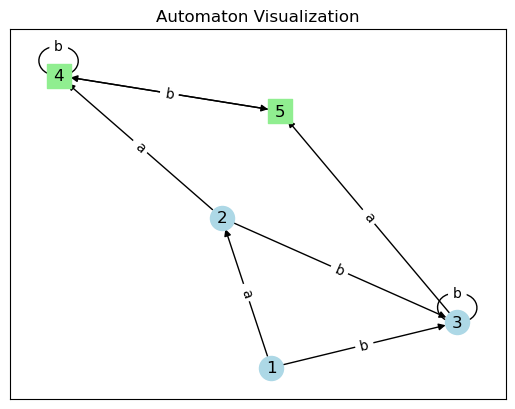

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

edges = [
    (1, 2, 'a'), # state 1 transitions to state 2 upon receiving 'a'
    (1, 3, 'b'),
    (2, 4, 'a'),
    (2, 3, 'b'),
    (3, 5, 'a'),
    (3, 3, 'b'),
    (4, 5, 'a'),
    (4, 4, 'b'),
    (5, 4, 'a'),
    (5, 4, 'b')
]
accepting = {4,5}
non_accepting = {1,2,3}

G = nx.DiGraph()
for st1, st2, label in edges:
    G.add_edge(st1, st2, label=label)
for state in accepting:
    G.add_node(state, accepting=True)

pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_nodes(G, pos, nodelist=accepting, node_color='lightgreen', node_shape='s')
nx.draw_networkx_nodes(G, pos, nodelist=non_accepting, node_color='lightblue', node_shape='o')
nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Automaton Visualization")
plt.show()


# Observation is Key

Mushing around the ideas that seem to be behind these sort of automata and generalizations a paradigm shows up. I don't really know exactly what I'd want to call this paradigm, but the following keywords are important.

- "observation" 
- "coalgebra" https://en.wikipedia.org/wiki/F-coalgebra
- "bisimulation" https://en.wikipedia.org/wiki/Bisimulation
- "automata"
- "object"
- "coinduction"  https://en.wikipedia.org/wiki/Coinduction
- "greatest fixed point" 
- "copattern" https://dl.acm.org/doi/10.1145/2480359.2429075
- "stream"
- "lazy"
- "rational" https://www.swi-prolog.org/pldoc/man?section=cyclic
- "negative polarity" (not so sure about this one?) https://ncatlab.org/nlab/show/polarity+in+type+theory
- "corecursion" https://en.wikipedia.org/wiki/Corecursion
- "codata" https://www.microsoft.com/en-us/research/uploads/prod/2020/01/CoDataInAction.pdf

Observation is the keyword I have in the past the found most frustrating, but now kind of think is the core of it. These rest sound like technobabble, but observation is a down to earth word.

The "best" or most natural data structure describing an automaton should be a mapping from "states" to a packaging of _all_ the possible observations of that state. In the case of our DFA above, it is a dictionary mapping to a tuple containing what state to transition to upon receiving "a", "b" and a bool of whether it is a final state. This is not a complicated representation, but not the first one I would grab without this "observation" philosophy in my head. And yet it really simplifies algorithms and generalizations.

In automata, we had something we called a state and I gave them abstract labels `1` or `A` or something. We make a distinction between these labels as mere bookkeeping devices. I could have systematically renamed state `A`  to state `42` and it wouldn't have mattered. This is similar to the dummy variable / alpha renaming problem that appears all over the syntax of math (integrals, sums, lambdas, etc).

If the state label _really_ has meaning, can actually be observed through some printout or LED or behavior, then that datum really shouldn't be stored in the state label. According to the philosophy I'm trying to explain, that "label" should really go into the observation data structure. The implementation should be free to mess around with the labels, renaming and compressing them, and it shouldn't matter to you. This is similar and related to the idea that in many high level languages, you shouldn't observe the numeric value of pointers. If you can, then a garbage collector is no longer free to move stuff around. All of this is a design _choice_, but these choices free the system to do some cool things for you.

A particular interesting choice we could make for representing our automata is as a dictionary/map from our state labels to the observations available for those states. Things like "color", "accepting/nonaccepting", or even the transitions accepted out of that state `list[action x state]`

In [20]:
from collections import namedtuple
Obs = namedtuple('Obs', ['accept', 'a_trans', 'b_trans'])
State = int
Automaton = dict[State, Obs]

ex1 : Automaton = {
  1 : Obs(False, 2, 3),
  2 : Obs(False, 4, 3),
  3 : Obs(False, 5, 3),
  4 : Obs(True, 5, 4),
  5 : Obs(True, 4, 4)
}

The state label is completely meaningless if it truly unobservable.

If I have state 1 who's only observation is "sour and "red" and state 2 whose only observation is "sour" and "red", in what sense are they really different? Well, we could make a rule that states that have the same observations should be compacted. That they are equal. In a loose sense, the state "is" the tuple `("sour", "red")`, except that states are identifiers, not tuples.

Things become a bit more interesting in the self referential case of an automaton like a DFA. The choice we make is that two states are equal if there can never be an observation that distinguishes them. So we seek a self consistent way of talking about sets of equivalent observations.

We start out by assuming no states are observationally distinguishable, discover where this is inconsistent, refine, and iterate.

In [18]:
import itertools
Partition = list[State]
PartMap = dict[State, Partition]

def dfa_map(f : PartMap, x : Automaton):
  # map function for observations. 
  return {n : Obs(accept, f[a], f[b])  for n, (accept, a, b) in x.items()}

states : list[State] = list(ex1.keys())
partmap = {i : states for i in range(1,6)}


for i in range(6): # iterate to stabilization
    print("partition map: ", partmap)
    # obs is the Automaton map with state ids replaced by  
    obs = dfa_map(partmap, ex1)
    partmap = {}
    for group_obs, equivs in itertools.groupby(states, lambda state: obs[state]):
        equivs = list(equivs)
        for id_ in equivs:
            partmap[id_] = equivs


partition map:  {1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5]}
partition map:  {1: [1, 2, 3], 2: [1, 2, 3], 3: [1, 2, 3], 4: [4, 5], 5: [4, 5]}
partition map:  {1: [1], 2: [2, 3], 3: [2, 3], 4: [4, 5], 5: [4, 5]}
partition map:  {1: [1], 2: [2, 3], 3: [2, 3], 4: [4, 5], 5: [4, 5]}
partition map:  {1: [1], 2: [2, 3], 3: [2, 3], 4: [4, 5], 5: [4, 5]}
partition map:  {1: [1], 2: [2, 3], 3: [2, 3], 4: [4, 5], 5: [4, 5]}


# Bits and Bobbles
Each of these I kind of want to do a blog post on, but I shouldn't be so precious about things.

## Non Well Founded Sets

A fun variation on the idea is non-well founded sets https://plato.stanford.edu/entries/nonwellfounded-set-theory/ . Instead of having a tuple of observations, the observations could be a set of things that are elements of the "state".
You can develop much of formal set theory under this paradigm, and it is quite often a better fit as a mathemtical description/denotation of computational phenomenon.

```python
universe : dict[State, set[State]] = {
    0 : set(),    
    1 : set(1,2),
    2 : set(1,2)
}
def minimize():
    pass

```

Books Non-Well-Founded Sets by Aczel and Vicious Circles for more. I have a suspicion this perspective is better for CLP(Set). Logic variables are lazy. They are also unexpanded until observed. lazy is coalgebraic. 

True unordered sets in haskell. Observations = separation queries
- <https://byorgey.github.io/blog/posts/2024/06/25/unordered-n-tuple-product.html>
- https://danryba253.github.io/danirybeblog/posts/unordered-n-tuples/
- https://gelisam.blogspot.com/2013/07/the-commutative-monad.html


## Incremental Minimization of Automata
There is a problem I've seen where you want to minimize your automata, but you need to automata to be "closed" before you have all your observations.
The trick I think is that observations need to be _forgotten_, not learned.
In order to plug a piece onto an automata you've already built, you need something like a state id or partition to plug on to. This means that that id is in fact _observable_ for now though, until we close/seal that state saying that we will never plug a new transition or learn a new fact. We then _forget_ that state label and allow it to be fused away by minimization.

```python

# 2 is not in domain of obs, hence "unexpanded"
# domain grows monotonically
obs = {
    1 : ("foo", 2)
}

# or keep explicit closed/open set. closed grows monotonically.
closed = {1}

```

This feels ensnared with ideas of closed / open as in closed world assumption https://en.wikipedia.org/wiki/Closed-world_assumption and closed vs open/extensible datatypes https://www.andres-loeh.de/OpenDatatypes.pdf . 

## Misc
Co-egraphs: next time. PEGs are basically streams. Streams are coalgebraic. Have an enode map `dict[ENode, EId]` and a Co-enode/observation map, `dict[OId, Obs]` Observations can include EId. Not exactly clear how disjoint to make EId vs OId (object id). Akin to maude or mcrl2 distinction between term-y stuff and state-y stuff. Rebuilding Does both union find congruence compaction and automata compaction. Observations must go down monotonically.

Under the hood, networkx is a dict of dicts implementing an adjacency list representation. There is no reason that their representation should be tuned to the use xcase of automata 

Fixpoints scream datalog to me. Datalog implements a least fixed point. Via negation/a bounded universe of discource, you can sometimes flip between least and greatest fixed points. Instead of deriving which states are equal, we can derive which are definitely not equal. The is the action of [partition refinement](https://en.wikipedia.org/wiki/Partition_refinement) (an idea and data structure)

Going faster. Jules Jacobs.boa tool in rust https://github.com/julesjacobs/boa https://dl.acm.org/doi/10.1145/3656454 Katch

 Damien Pous https://perso.ens-lyon.fr/damien.pous/

mcrl2 https://mcrl2.org/web/index.html

Alexandra Silva has great resources. See also OPLSS lectures
[[POPL'22] Coalgebra for the working programming languages researcher](https://www.youtube.com/watch?v=Qb0z1FWT5bw&ab_channel=ACMSIGPLAN)
https://www.youtube.com/watch?v=TEFx5DG9ghE&t=1628s&pp=ygUOYXV0b21hdGEgc2lsdmE%3D kleene algerva and applications

Automata minimization is kind of like the dual of hash consing. Terms can be uniformly represented by a dict `Constructor -> id`. Deduplication of this can be done in a loop using a union find. This is like an egraph without an extra notion of equality coming in. Only those implied by congruence.

```python
Term = namedtuple("Term", ["head","children"]) # Enode

ex2 = [
    (Term("a",()) ,    0)
    (Term("a",()) ,    1),
    (Term("foo", (0,)), 2),
    (Term("foo", (1,)), 3)
]

equiv = {t : }
def fmap(f, t):
    head, *args = t:
    return (head,) + tuple(map(f,args))

for (term, eid) in 
```



Immutable object oriented programming. You can program in an object oriented style such that you never mutate your objects. When you need to "set", you hand back a copy of yourself with the appropriate updates. This is ludicrous from the low level C++ perspective in many situations (except perhaps multithreading/concurrent/distributed stuff), but the perspective can help bridge between the pure functional world and the object oriented world. In turn, the functional world is closer to a "mathematical" style of thinking. I don't think I have a value judgement on what is better, but I have wandering personal preferences.

Lurking in the background of all of this, like a ghoul, is category theory. I don't think it clarifies anything.

Generalizations of DFA. Probablistic, Nondet.


Co-logic programming is cool. Consistency. Watch your stack to see if you've come back to the same question.
<https://personal.utdallas.edu/~gupta/ppdp06.pdf>  Co-Logic Programming: Extending Logic Programming
with Coinduction L. Simon, A. Mallya, A. Bansal, G. Gupta
<https://twitter.com/sivawashere/status/1364734181545238532>
<https://logtalk.org/papers/colp2012/coinduction_colp2012_slides.pdf>

CoCaml https://www.cs.cornell.edu/projects/CoCaml/

- informal informal set theory - sets of urelement / objects. we don't really iterate the concepts of sets. We don't really consider encodings of objects into sets. We use set builder notation to kind of describe the thing we're talking about. Unions and intersections. The level of set theory that is in the front matter of a calculus textbook.
- informal formal set theory - Formal set theory but without using much explicit formalism of first order logic / symbol manipulation. We are kind of intrigued by encodings. This is probably where most of. Set Theory textbooks. "Naive Set Theory" by halmos
- formal formal set theory - for serious being very careful about symbolic manipulations at the level it is all computer implementable. There are constructions presented in textbooks that I don't really know how to break down into basic axiomatic components. This is probably a pretty serious and useful homework exercise in each case. And maybe research paper worthy if it ends up not being as trivial as assumed.

(What is formal informal set theory?)

# Datalog Ramblings
## Coinductive or Greatest Fixed Point Datalog

Does this make sense?
There is coinductive logic programming which is prolog

In semantics of ASP, stable semantics, I seem to recall them talking about the ast and greatest model.

LFP is the minimum
GFP is the maximal consistent set

```
// a co-fact
:- foo().

// can be translated into datalog. This is intuitionistic-ish negation
neg_foo().

// A co-axiom / co-rule
bar() :- foo(), biz().
// expands to 2 backwards derivation rules. Feels a bit like seminaive expansion
// Also kind f demand-y. Maybe magic set-t
neg_foo() :- biz(), neg_bar().
neg_biz() :- neg_bar(), foo().



```

Datalog builds finite sets. Co-datalog builds co-finite sets.

This _is_ a valid ASP program, but maybe we're targetting a subset that is treatble

```clingo
:- foo().
bar() :- foo(), biz().
```

Making a negatin relation is a good trick. It turns the union of datalog into an intersection.
One could imagine a datalog that fills the database o start with and removes facts as they become inconsistent, but why not just list the facts that are known to not hold.

The well founded semntics seems to be the best match here.

has non terminating path is a kind of liveness property. It is analagous in some respects to reachability (vertex specialized path query).
has-infinite-trace is another way of putting it.

```souffle
.type vert = number

.decl no_cycle(v : vert)
.decl edge(x : vert, y : vert)
//.decl no_edge(x:vert, y:vert)

edge(1,2). edge(2,3). edge(3,3).
edge(3,4). edge(4,5). edge(3,5).

edge(7,8). edge(8,7).
verts(v) :- edge(v,_) ; edge(_, v).
//no_edge(x,y) :- 

.decl verts(x : vert)
// This is out0
no_cycle(v) :- verts(v), !edge(v, _). // no outgoing egde, can't have a cycle
// no_cycle(x) :- forall y: edge(x,y), no_cycle(y).
// finite expansiosn. no. Well, if we specialzied the rules to the particular graph.
// in2 in3 in4
.decl out1(v : vert)
out1(v) :- verts(v), 1 = count : {edge(v,_)}.
.decl out2(v : vert)
out2(v) :- verts(v), 2 = count : {edge(v,_)}.
.decl out3(v : vert)
out3(v) :- verts(v), 3 = count : {edge(v,_)}.

no_cycle(x) :- out1(x), edge(x,y), no_cycle(y).
no_cycle(x) :- out2(x), edge(x,y1), no_cycle(y1),
               y1 != y2, edge(x,y2), no_cycle(y2).
no_cycle(x) :- out3(x), edge(x,y1), no_cycle(y1),
               y1 != y2, edge(x,y2), no_cycle(y2),
               y1 != y3, y3 != y3, edge(x,y3), no_cycle(y3).

// maybe recursive count would work if that existed
// Bounded quantification by edge in previous strata is in principle nonproblematic.
// no_cycle(x) :- forall edge(x,y) : { no_cycle(y)  }
// no_cycle(x) :- verts(x), count : { edge(x,y) } = count : { edge(x,y1), no_cycle(y1) }

.output no_cycle()
.output verts

// Compare with this definition
.decl cycle(v : vert)

.decl path(x : vert, y : vert)
path(x,y) :- edge(x,y).
path(x,z) :- edge(x,y), path(y,z).
cycle(x) :- path(x,x).

cycle(x) :- edge(x,y), cycle(y).
.output cycle
// Ok this is a very natural encoding. Is it missing anything?


// I ges finitely expanding the cycles is an extremely stupid idea.
//cycle(x) :- edge(x,x).
// Misses the 7,8 cycle
// We could finitely expand the primitive cycle finder though up to N. Is this really worse than the finite expansion I did above?
// cycle(x) :- edge(x,y), edge(y,x).
// transitive closure to reach cycle
```

If there are multiple rules, they all have to fail to propagate a negation.
The negation also plays into the quantifier structure.
This is perhaps related to performing the (clark) completion of a program.

For co-datalog, this ought to be the only rule necessary.
`inf_trace(x) :- edge(x,y), inf_trace(y)`
start with all possiblites in inf_trave, run "backwards" through rule? Since this is linear, can see it, but what about nonlinear or mutually recursive ruls?
forall x, (exists y, edge(x,y), t(y)) -> t(x)
Has to be run "seminaive"?
forall x, not (exists edge /\ t(y)) \/ t(x)
forall x, (not not forall (not edge \/ not t(y)) \/ t(x)
forall x, (not not forall (not edge \/ not t(y)) \/ t(x)

forall x, not not t(x) \/ (exists edge, t(y))

Hmm. Clingo is not panacea I pretended it might be. Clingo is still very least fixpoint based.

```clingo
edge(1,2). 
edge(2,3). 
edge(3,3).
edge(3,4). 
edge(4,5). 
edge(3,5).
vert(V) :- edge(V,_).
vert(V) :- edge(_, V).

%inf_trace(X) :- vert(X), not edge(X,_).
%{inf_trace(V): edge(V, W)} :- inf_trace(W).
%{-inf_trace(V)} :- vert(V). 
%-inf_trace(Y) :- edge(X,Y), -inf_trace(X).

-inf_trace(X) :- vert(X), -inf_trace(Y) : edge(X,Y).
inf_trace(X) :- vert(X), not -inf_trace(X). %If it's not disprovable, it's true.
```

I don't _really_ feel like clingo is necessary, but it does have some nice features.
The conditional rule using bounded quantification to a previous strata is safe.

Maybe I need to construct all possible proofs and only remove somthing when there are no allowable extant proofs.

### DFA Minimization

```souffle
.type state = symbol
.type action = number
.decl states(s : state)
.decl start(s : state)
.decl accept(s : state)
.decl trans(s : state, a : action, s1 : state)
// https://en.wikipedia.org/wiki/DFA_minimization
states("a"). states("b"). states("c"). states("d"). states("e"). states("f").
start("a").
accept("d"). accept("c"). accept("e").
trans("a",0,"b").trans("a",1,"c").
trans("b",0,"a").trans("b",1,"d").
trans("c",1,"f").trans("c",0,"e").
trans("d",0,"e").trans("d",1,"f").
trans("e",0,"e").trans("e",1,"f").
trans("f",0,"f").trans("f",1,"f").

.decl distinct(s : state, t : state)
distinct(a,b) :- accept(a), states(b), !accept(b).
distinct(s,t) :- trans(s,a,s1), trans(t,a,t1), distinct(s1,t1). 
distinct(s,t) :- distinct(t,s). //symmetry

.decl eq(s : state, t : state)
eq(a,b) :- states(a), states(b), !distinct(a,b).

//.decl root(s : state, t : state)
//root(a,b) :- states(a), min b: eq(a,b).
.output eq
```

[local and symbolic bisimlation using tabled constraint logic programming](https://www3.cs.stonybrook.edu/~cram/Papers/BMRRV_ICLP01/paper.pdf)

```clingo
obs(hd,a,3).
obs(tl,a,b).
obs(hd,b,4).
obs(tl,b,a).
eq(X,X) :- obs(hd, A, X).
-eq(X,Y) :- obs(O,X,OX), obs(O,Y,OY). %not eq(OY,OX). % OX != OY. %-eq(OY,OX).


```